Heavily based on https://github.com/epignatelli/cardiax

In [42]:
import jax
import jax.numpy as np


def params_to_units(params, dx, dt):
    params["Cm"] /= (dx ** 2) / dt
    params["tau_d"] /= dt
    params["tau_v1_minus"] /= dt
    params["tau_v2_minus"] /= dt
    params["tau_v_plus"] /= dt
    params["tau_0"] /= dt
    params["tau_r"] /= dt
    params["tau_si"] /= dt
    params["tau_w_minus"] /= dt
    params["tau_w_plus"] /= dt
    return params


def diffusivity_to_units(d, dt):
    return d / dt


def diffusivity_rescale(c, domain):
    a, b = c.min(), c.max()
    y, z = domain[0], domain[1]
    return (c - a) * (z - y) / (b - a) + y


def realsize_to_shape(field, dx):
    return (int(field[0] / dx), int(field[1] / dx))


def shape_to_realsize(field, dx):
    return (int(field[0] * dx), int(field[1] * dx))


def cm_to_units(value, dx):
    return int(value / dx)


def units_to_cm(value, dx):
    return value * dx


def ms_to_units(value, dt):
    return int(value / dt)


def units_to_ms(value, dt):
    return value * dt


def stimuli_to_units(stimuli, dx, dt):
    stimuli = list(stimuli)
    for i in range(len(stimuli)):
        stimuli[i]["start"] = ms_to_units(stimuli[i]["start"], dt)
        stimuli[i]["duration"] = ms_to_units(stimuli[i]["duration"], dt)
        stimuli[i]["period"] = ms_to_units(stimuli[i]["period"], dt)
    return stimuli


def u_to_V(u, V0=-85, Vfi=15):
    return ((Vfi - V0) * u) + V0


def V_to_u(V, V0=-85, Vfi=15):
    return (V - V0) / (Vfi - V0)

In [54]:
from enum import Enum
from typing import Any, Callable, NamedTuple
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.experimental import ode

class State(NamedTuple):
    v: jnp.ndarray
    w: jnp.ndarray
    u: jnp.ndarray


@functools.partial(jax.jit, static_argnums=0)
def init(shape):
    v = jnp.ones(shape)
    w = jnp.ones(shape)
    u = jnp.zeros(shape)
    return State(v, w, u)



@functools.partial(jax.jit, static_argnums=1)
def gradient(a, axis):
    sliced = functools.partial(jax.lax.slice_in_dim, a, axis=axis)
    a_grad = jnp.concatenate(
        (
            # 3th order edge
            (
                (-11 / 6) * sliced(0, 2)
                + 3 * sliced(1, 3)
                - (3 / 2) * sliced(2, 4)
                + (1 / 3) * sliced(3, 5)
            ),
            # 4th order inner
            (
                (1 / 12) * sliced(None, -4)
                - (2 / 3) * sliced(1, -3)
                + (2 / 3) * sliced(3, -1)
                - (1 / 12) * sliced(4, None)
            ),
            # 3th order edge
            (
                (-1 / 3) * sliced(-5, -3)
                + (3 / 2) * sliced(-4, -2)
                - 3 * sliced(-3, -1)
                + (11 / 6) * sliced(-2, None)
            ),
        ),
        axis,
    )
    return a_grad


@jax.jit
def step(state, t, params, diffusivity, stimuli, dx):
    # neumann boundary conditions
    v = jnp.pad(state.v, 1, mode="edge")
    w = jnp.pad(state.w, 1, mode="edge")
    u = jnp.pad(state.u, 1, mode="edge")
    diffusivity = jnp.pad(diffusivity, 1, mode="edge")

    # reaction term
    p = jnp.greater_equal(u, params.V_c)
    q = jnp.greater_equal(u, params.V_v)
    tau_v_minus = (1 - q) * params.tau_v1_minus + q * params.tau_v2_minus

    j_fi = -v * p * (u - params.V_c) * (1 - u) / params.tau_d
    j_so = (u * (1 - p) / params.tau_0) + (p / params.tau_r)
    j_si = -(w * (1 + jnp.tanh(params.k * (u - params.V_csi)))) / (2 * params.tau_si)
    j_ion = -(j_fi + j_so + j_si) / params.Cm

    # apply stimulus by introducing fictitious current
    stimuli = [s._replace(field=jnp.pad(s.field, 1, mode="edge")) for s in stimuli]
    j_ion = stimulate(t, j_ion, stimuli)

    # diffusion term
    u_x = gradient(u, 0) / dx
    u_y = gradient(u, 1) / dx
    u_xx = gradient(u_x, 0) / dx
    u_yy = gradient(u_y, 1) / dx
    D_x = gradient(diffusivity, 0) / dx
    D_y = gradient(diffusivity, 1) / dx
    del_u = diffusivity * (u_xx + u_yy) + (D_x * u_x) + (D_y * u_y)

    d_v = ((1 - p) * (1 - v) / tau_v_minus) - ((p * v) / params.tau_v_plus)
    d_w = ((1 - p) * (1 - w) / params.tau_w_minus) - ((p * w) / params.tau_w_plus)
    d_u = del_u + j_ion

    return State(
        d_v[1:-1, 1:-1],
        d_w[1:-1, 1:-1],
        d_u[1:-1, 1:-1],
    )


def step_euler(state, t, params, diffusivity, stimuli, dt, dx):
    grads = step(state, t, params, diffusivity, stimuli, dx)
    return jax.tree_map(lambda v, dv: jnp.add(v, dv * dt), state, grads)


@jax.jit
def _forward_euler(state, t, t_end, params, diffusivity, stimuli, dt, dx):
    state = jax.lax.fori_loop(
        t,
        t_end,
        lambda i, state: step_euler(state, i, params, diffusivity, stimuli, dt, dx),
        init_val=state,
    )
    return state


def forward(
    state,
    checkpoints,
    params,
    diffusivity,
    stimuli,
    dt,
    dx,
):
    states = []
    for i in range(len(checkpoints) - 1):
        state = _forward_euler(
            state,
            float(checkpoints[i]),
            float(checkpoints[i + 1]),
            params,
            diffusivity,
            stimuli,
            dt,
            dx,
        )
        states.append(state)
    return states


def forward_dimensional(
    tissue_size,
    final_time,
    ms_step,
    params,
    diffusivity,
    stimuli,
    dt,
    dx,
):
    shape = realsize_to_shape(tissue_size, dx)
    start = 0
    stop = ms_to_units(final_time, dt)
    step = ms_to_units(ms_step, dt)

    assert shape == diffusivity.shape
    assert all([s.field.shape == shape for s in stimuli])

    state = init(shape)
    checkpoints = jnp.arange(start, stop, step)
    return forward(
        state,
        checkpoints,
        params,
        diffusivity,
        stimuli,
        dt,
        dx,
    )



@jax.jit
def stimulate(t, X, stimuli):
    stimulated = jnp.zeros_like(X)
    for stimulus in stimuli:
        # check if stimulus is in the past
        active = jnp.greater_equal(t, stimulus.protocol.start)
        # check if stimulus is active at the current time
        active &= (
            jnp.mod(stimulus.protocol.start - t + 1, stimulus.protocol.period)
            < stimulus.protocol.duration
        )
        # build the stimulus field
        stimulated = jnp.where(stimulus.field * (active), stimulus.field, stimulated)
    # set the field to the stimulus
    return jnp.where(stimulated != 0, stimulated, X)

In [44]:
import random
from typing import NamedTuple, Tuple
from enum import IntEnum

import jax
import jax.numpy as np
from scipy.ndimage import rotate

Shape = Tuple[int, ...]
Point2D = Tuple[int, int]


class Protocol(NamedTuple):
    start: int
    duration: int
    period: int


class Stimulus(NamedTuple):
    protocol: Protocol
    field: np.ndarray


class Direction(IntEnum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3


def rectangular(
    shape: Shape,
    centre: Point2D,
    size: Point2D,
    modulus: float,
    protocol: Protocol,
):
    mask = np.zeros(shape, dtype="float32")
    x1 = int(centre[0] - size[0] / 2)
    x2 = int(centre[0] + size[0] / 2)
    y1 = int(centre[1] - size[1] / 2)
    y2 = int(centre[1] + size[1] / 2)
    mask = jax.ops.index_update(mask, jax.ops.index[x1:x2, y1:y2], modulus)
    return Stimulus(protocol, mask)


def linear(
    shape: Shape,
    direction: Direction,
    coverage: float,
    modulus: float,
    protocol: Protocol,
):
    stripe_size = int(shape[0] * coverage)
    field = np.zeros(shape, dtype="float32")
    if direction == Direction.WEST:
        field = field.at[:, :stripe_size].set(modulus)
    elif direction == Direction.EAST:
        field = field.at[:, -stripe_size:].set(modulus)
    elif direction == Direction.NORTH:
        field = field.at[:stripe_size, :].set(modulus)
    elif direction == Direction.SOUTH:
        field = field.at[-stripe_size:, :].set(modulus)
    else:
        raise ValueError(
            "direction mus be either 'left', 'right', 'up', or 'down' not %s"
            % direction
        )
    return Stimulus(protocol, field)


def triangular(
    shape: Shape,
    direction: float,
    angle: float,
    coverage: float,
    modulus: float,
    protocol: Protocol,
):

    stim = linear(shape, direction, coverage, modulus, protocol)
    field = rotate(
        stim.field, angle=angle, mode="nearest", prefilter=False, reshape=False
    )
    return Stimulus(protocol, field)

In [45]:
from typing import NamedTuple


class Params(NamedTuple):
    tau_v_plus: float
    tau_v1_minus: float
    tau_v2_minus: int
    tau_w_plus: int
    tau_w_minus: int
    tau_d: float
    tau_0: float
    tau_r: int
    tau_si: int
    k: int
    V_csi: float
    V_c: float
    V_v: float
    Cm: float


PARAMSET_3 = Params(
    3.33, 19.6, 1250, 870, 41, 0.25, 12.5, 33.33, 29, 10, 0.85, 0.13, 0.04, 1
)

In [46]:
"""
utils_scars.py by Stef Garasto

Description.

Utils to help generate a scar map consisting of multiple overlapping polygons created by
using a closed spline curve as their contours (with the option to add a gap in the middle).
By varying the parameters a wide range of scar maps can be generated.

Specifics:

First, the centroids of the different objects making up the scar are created by selecting a
subset of adjacent points from a pertured spline curve (see CreateSplineCentroids).
The number of selected points gives the number of closed splines objects to generate and add together.

After it generates this number of closed spline curves (randomly perturbed), it converts them
to binary images and sums them together as an OR operation (see MakeAndSumCompositeBlob).
Individual Splines object are shifted based on their individual centroid and a global centroid.
The global centroid defines where they are in the image, the individual centroids define where
they are wrt each other. Aside from being shifted, they are also scaled to fit within a larger image.
The scale ratio is given by specifying how the big one wants the image to be and what the scale of
the scar wrt to the full image should be.

The scale factor is basically the scale factor between the width/height of the image and the shorter
side of the composite scar (well, at least it is roughly that, I think - this part is done a bit in
an approximate way).

Then, the final image is smoothed to create a tapered edge (see SoftenPolyAndSplineCurve).
To do this, the function requires a given average size (AvgEdgeSize) for the edges coming
out of the convolution. The function will do its best to find the gaussian filter that gets
us as close as possible to the required size (within a certain range). AvgEdgeSize can be
specified either in pixels (>1 values) or in proportions (<1 values). The alternative would
be to convolve with a fixed sixe Gaussian (also implemented), but this doesn't control for the
size of the resulting edge.
"""

import logging
from typing import Tuple

import jax
import jax.numpy as jnp
from jax.scipy.signal import convolve2d
from scipy import interpolate
from skimage.draw import polygon

def_params = {}
def_params["maxProtrudeFactorCentroid"] = 0.2
def_params["r0Centroid"] = 1.5
def_params["maxProtrudeFactor"] = 0.2
def_params["r0"] = 1
def_params["ScarScaleFactor"] = 0.4
def_params["RequiredImageSize"] = (1200, 1200)
def_params["CONSERVATIVE_CENTROID"] = True
def_params["GaussSigma"] = 2
def_params["RequiredAvgEdgeSize"] = 22  # in pixels
def_params["ADD_GAP"] = False
def_params["GapFactor"] = 0.5

def_shortID = "BJdY4KfkSDsa4wPe7i3HPb"

def_root_file_name = "data/scars_maps/{content}_{ID}.{ext}"


def makegauss2D(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss - 1.0) / 2.0 for ss in shape]
    y, x = jnp.meshgrid(jnp.arange(-m, m + 1), jnp.arange(-n, n + 1))
    h = jnp.exp(-(x * x + y * y) / (2.0 * sigma * sigma))
    h = h.at[h < jnp.finfo(h.dtype).eps * h.max()].set(0)
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def drawpolyintoemptycanvas(shape, x, y, tx, ty):
    """
    Purpose is to draw a polygon into an empty canvas (image)
    for the purpose of subseuqntly combining it with an existing canvas
    The offsets can be chosen so that the polygon does not exceed
    the boundaries of the polygon
    """
    img = jnp.zeros(shape, dtype=float)

    R = shape[1] - (ty + y)
    C = tx + x

    R = jnp.clip(R, 0, shape[1])
    C = jnp.clip(C, 0, shape[0])

    rr, cc = polygon(R, C)
    img = img.at[rr, cc].set(1)

    return jnp.array(img)


def makePolyAndSplineCurve(rng, r0=30, maxProtrudeFactor=0.3, NGon=11, NSplinePts=100):
    rng_1, _ = jax.random.split(rng)
    maxPerturbMag = maxProtrudeFactor * r0

    delta_t = 1 / (NGon - 1)
    t = jnp.arange(0, 1 + delta_t, delta_t)

    # obtain perturbation to the radius based on a slightly shifted and scaled gaussian
    # this is to skew the values towards the positive range
    rperturbation = (jax.random.normal(rng_1, (NGon,)) + 0.5) * jnp.power(0.6, 2)

    rdash = r0 + maxPerturbMag * rperturbation

    Px = rdash * jnp.sin(2 * jnp.pi * t)
    Py = rdash * jnp.cos(2 * jnp.pi * t)

    # Close the curve
    Px = Px.at[-1].set(Px[0])
    Py = Py.at[-1].set(Py[0])

    delta_u = 1 / NSplinePts
    tck, u = interpolate.splprep([Px, Py], s=0)
    unew = jnp.arange(0, 1 + delta_u, delta_u)
    SplinePts = interpolate.splev(unew, tck)

    return (Px, Py), SplinePts


def PolyAndSplineCurve2Mask(SplinePts, CxSize=100, CySize=100, tx=None, ty=None):
    """Transform a Spline Curve defined by its points into a binary? image with size (CxSize, CySize) and
    with 1 inside the curve and 0 outside"""
    if tx is None:
        tx = CxSize / 2
    if ty is None:
        ty = CySize / 2

    # create image from spline points
    MapMaskSp = drawpolyintoemptycanvas(
        (CxSize, CySize), SplinePts[0], SplinePts[1], tx, ty
    )

    return MapMaskSp


def GetAvgEdgeSize(softened_mask):
    """ Get average number of pixels on each row that are between 0 and 1"""
    edge_size_sum = []
    edge_size_mean = []
    for i in range(softened_mask.shape[0]):
        row_edge_sum = ((softened_mask[i] > 0) & (softened_mask[i] < 0.99)).sum()
        row_edge_mean = ((softened_mask[i] > 0) & (softened_mask[i] < 0.99)).mean()

        if row_edge_sum > 0:
            edge_size_sum.append(row_edge_sum)
            edge_size_mean.append(row_edge_mean)
    """ edge_size_sum is in PIXELS, edge_size_mean is in PROPORTION OF IMAGE SIZE"""
    # take average across rows. Divide by 2 because there are usually two edges
    avg_edge_size_pixel = jnp.mean(edge_size_sum) / 2
    avg_edge_size_prop = jnp.mean(edge_size_mean) / 2
    return avg_edge_size_pixel, avg_edge_size_prop


def SoftenPolyAndSplineCurve(
    MapMaskSp, GaussShape=7, GaussSigma=3, AvgEdgeSize=None, verbose=False
):
    """Taper the edge of an image of a spline curve generated by PolyAndSplineCurve2Image.
    AvgEdgeSize can be specified either in pixels (>1 values) or in proportions (<1 values)"""

    def ConvolveAndAvgEdge(n, sigma):
        # create 2D filter, convolve and get avg edge size
        g2_a = makegauss2D(shape=(n, n), sigma=sigma)

        LocalSoftenedBlob = convolve2d(MapMaskSp, g2_a, "same")
        local_avg_edge_size_pixel, local_avg_edge_size_prop = GetAvgEdgeSize(
            LocalSoftenedBlob
        )
        return LocalSoftenedBlob, local_avg_edge_size_pixel, local_avg_edge_size_prop

    assert GaussSigma or AvgEdgeSize

    if GaussSigma:
        """used a fixed size for the Gaussian filter.
        If both GaussShape and AvgEdgeSize are specified, the former gets priority"""
        SoftenedBlob, avg_edge_size_pixel, avg_edge_size_prop = ConvolveAndAvgEdge(
            GaussShape, GaussSigma
        )
        if verbose:
            print(f"Gaussian filter shape: {GaussShape}")
            print(f"Average edge size: {avg_edge_size_pixel:.2f} (in absolute pixels)")
            print(f"Average edge size: {avg_edge_size_prop:.2f} (in relative pixels)")

    else:
        """ define the size of the Gaussian filter based on the required avg edge size"""
        # decide whether we are dealing with pixels or
        IS_PIXELS = AvgEdgeSize > 1
        # do multiple convolutions and get avg edge size

        edge_size_diff = []
        CandidateGaussSigmas = jnp.arange(2, 10)
        for iGaussShape in CandidateGaussSigmas:
            (
                _,
                iavg_edge_size_pixel,
                iavg_edge_size_prop,
            ) = ConvolveAndAvgEdge(iGaussShape, GaussSigma)
            iavg_edge_size = iavg_edge_size_pixel if IS_PIXELS else iavg_edge_size_prop
            edge_size_diff.append(jnp.abs(iavg_edge_size - AvgEdgeSize))

        # choose the gaussian size that gives the best results
        GaussShape = CandidateGaussSigmas[jnp.argmin(edge_size_diff)]
        # recompute softened image
        SoftenedBlob, avg_edge_size_pixel, avg_edge_size_prop = ConvolveAndAvgEdge(
            GaussShape, GaussSigma
        )
        if verbose:
            print(f"Gaussian filter shape: {GaussShape}")
            print(f"Average edge size: {avg_edge_size_pixel:.2f} (in absolute pixels)")
            print(f"Average edge size: {avg_edge_size_prop:.2f} (in relative pixels)")

    # return all of the results
    return SoftenedBlob, avg_edge_size_pixel, avg_edge_size_prop, GaussShape


# Create function to determine centerline for blobs
def CreateSplineCentroids(rng, params=def_params):
    """generate centroids for all closed spline objects as a section of
    another spline curve"""
    rng_1, rng_2, rng_3 = jax.random.split(rng, 3)
    r0 = params["r0Centroid"]
    maxProtrudeFactor = params["maxProtrudeFactorCentroid"]

    if r0 is None:
        r0 = 1
    if maxProtrudeFactor is None:
        maxProtrudeFactor = 0.2

    P, _ = makePolyAndSplineCurve(
        rng_1, r0=r0, maxProtrudeFactor=maxProtrudeFactor, NGon=12
    )
    Npoints = jax.random.randint(rng_2, (1,), 3, 7)[0]
    m = len(P[0])
    starting_point = jax.random.randint(rng_3, (1,), 0, m)[0]  # m / 4, m / 4 * 3)
    select_points = jnp.arange(starting_point, starting_point + Npoints) % len(P[0])
    return (P[0][select_points], P[1][select_points])


def MakeAndSumCompositeBlob(rng, params=def_params, CentroidSpline=None):
    """
    Generates a number of closed splines objects based on how many points
    there are in the CentroidSpline input.
    Converts them to binary images and sums them together as an OR operation.
    Individual Splines object are shifted based on their individual centroid
    and a global centroid. The global centroid defines where they are in the
    image, the individual centroids define where they are wrt each other.
    Aside from being shifted, they are also scaled to fit within a larger image.
    The scale ratio is given by specifying how the big one wants the image to be
    and what the scale of the scar wrt to the full image should be.
    The scale factor is basically the scale factor between the width/height of the
    image and the shorter side of the composite scar (well, at least it is roughly
    that, I think - this part is done a bit in an approximate way).

    params is a dict with the variables outlined below.

    CentroidSpline is a list of centroids returned by CreateSplineCentroids

    """
    # make rngs
    rng_1, rng_2, rng_3, rng_4 = jax.random.split(rng, 4)

    if CentroidSpline is None:
        CentroidSpline = CreateSplineCentroids(rng_1, params=params)

    # recreate parameters as individual variables
    maxProtrudeFactorCentroid = params["maxProtrudeFactorCentroid"]
    r0Centroid = params["r0Centroid"]
    maxProtrudeFactor = params["maxProtrudeFactor"]
    r0 = params["r0"]
    ScarScaleFactor = params["ScarScaleFactor"]
    RequiredImageSize = shape = params["RequiredImageSize"]
    CONSERVATIVE_CENTROID = params["CONSERVATIVE_CENTROID"]
    ADD_GAP = params["ADD_GAP"]
    GapFactor = params["GapFactor"]

    # calculate some extra factors
    nBlobs = CentroidSpline[0].shape[0]
    maxCentroidExtension = r0Centroid + maxProtrudeFactorCentroid
    maxExtension = maxCentroidExtension + maxProtrudeFactor + r0
    doubleExtension = maxExtension * 2
    halfExtension = maxExtension / 2
    ScarBaseImages = []
    ScarBasePtsNorm = []
    ScarBasePts = []

    for i in range(nBlobs):
        rng_2, rng_3 = jax.random.split(rng_2)
        # create and store 'normalised' points
        _, SplinePts = makePolyAndSplineCurve(
            rng_2, r0=r0, maxProtrudeFactor=maxProtrudeFactor
        )
        ScarBasePtsNorm.append(SplinePts)

        # center the blobs around the ith point in the centroid spline
        for j in range(2):
            SplinePts[j] += CentroidSpline[j][i]
            # P[j] += CentroidSpline[j][i]
        ScarBasePts.append(SplinePts)
        # if we already know we want to add a central gap, we should create a second, smaller, blob at the mid centroid
        if ADD_GAP & (i == nBlobs // 2):
            _, GapPts = makePolyAndSplineCurve(
                rng_3,
                r0=r0 * GapFactor,
                maxProtrudeFactor=maxProtrudeFactor * GapFactor,
            )
            for j in range(2):
                GapPts[j] += CentroidSpline[j][i]
        else:
            GapPts = 0
            GapMask = 0

    # set the overall location in the image
    maxField = jnp.ceil(maxExtension / ScarScaleFactor)
    RequiredImageRatio = RequiredImageSize[0] / RequiredImageSize[1]
    if RequiredImageRatio == 1:
        maxFieldX, maxFieldY = maxField, maxField
    elif RequiredImageRatio > 1:
        # wider image
        maxFieldX, maxFieldY = jnp.ceil(RequiredImageRatio) * maxField, maxField
    else:
        # 'taller' image
        maxFieldX, maxFieldY = maxField, jnp.ceil(RequiredImageRatio) * maxField

    rng_41, rng_42 = jax.random.split(rng_4)
    x = jax.random.uniform(rng_41)
    y = jax.random.uniform(rng_42)
    if CONSERVATIVE_CENTROID:
        GlobalCentroid = (
            (maxFieldX - doubleExtension) * x + maxExtension,
            (maxFieldY - doubleExtension) * y + maxExtension,
        )
    else:
        GlobalCentroid = (
            (maxFieldX - maxExtension) * x + halfExtension,
            (maxFieldY - maxExtension) * y + halfExtension,
        )

    FieldImageRatio = (
        maxFieldX / RequiredImageSize[0],
        maxFieldY / RequiredImageSize[1],
    )
    for i in range(nBlobs):
        for j in range(2):
            ScarBasePts[i][j] += GlobalCentroid[j]
            ScarBasePts[i][j] /= FieldImageRatio[j]
            ScarBasePts[i][j] = ScarBasePts[i][j] * (ScarBasePts[i][j] > 0)
    if ADD_GAP:
        for j in range(2):
            GapPts[j] += GlobalCentroid[j]
            GapPts[j] /= FieldImageRatio[j]
            GapPts[j] = GapPts[j] * (GapPts[j] > 0)

    # create images
    scar = jnp.zeros(shape)
    for i in range(nBlobs):
        x = PolyAndSplineCurve2Mask(
            ScarBasePts[i], CxSize=shape[0], CySize=shape[1], tx=0, ty=0
        )
        scar += x
    scar = jnp.clip(scar, a_max=1.0)

    if ADD_GAP:
        GapMask = PolyAndSplineCurve2Mask(
            GapPts, CxSize=RequiredImageSize[0], CySize=RequiredImageSize[1], tx=0, ty=0
        )
        scar = jnp.where(GapMask == 1.0, GapMask)

    # make sure the final image is between 0 and 1
    if scar.max() > scar.min():
        scar = (scar - scar.min()) / (scar.max() - scar.min())
    else:
        scar = jnp.zeros(shape)
        scar[shape[0] // 2, shape[1] // 2] = 1.0

    res_dict = {}
    res_dict["CompositeSplineMask"] = scar
    res_dict["ScarBaseImages"] = ScarBaseImages
    res_dict["ScarBasePts"] = ScarBasePts
    res_dict["ScarBasePtsNorm"] = ScarBasePtsNorm
    res_dict["GapPts"] = GapPts
    res_dict["GapMask"] = GapMask
    res_dict["GlobalCentroid"] = GlobalCentroid
    res_dict["CentroidSpline"] = CentroidSpline
    res_dict["maxFieldX"] = maxFieldX
    res_dict["maxFieldY"] = maxFieldY
    res_dict["nBlobs"] = nBlobs

    return res_dict


def random_spline(rng, params, centroids):
    return MakeAndSumCompositeBlob(rng, params, centroids)["CompositeSplineMask"]


def blur_scar(scar, gaussian_size, sigma):
    # create 2D filter, convolve and get avg edge size
    kernel = makegauss2D(shape=(gaussian_size, gaussian_size), sigma=sigma)
    blurred_scar = convolve2d(scar, kernel, "same")
    return blurred_scar


def random_diffusivity_scar(rng, shape: Tuple[int, ...]):
    rng_1, rng_2, rng_3, rng_4 = jax.random.split(rng, 4)
    params = def_params
    # replace size
    params["RequiredImageSize"] = shape
    # params["ScarScaleFactor"] = jax.random.randint(rng_3, (1,), 1, 8) / 10
    centroids = CreateSplineCentroids(rng_1, params)

    # Create individual blobs, scale them up and combine them
    scar = random_spline(rng_2, params, centroids)

    # taper the edges
    blur_kerne_size = int(
        shape[0] * 0.1
    )  #  kernel size is 3% of the image size - or 10%?
    blur_sigma = jax.random.normal(rng_4, (1,)) * shape[0] / 10
    scar = blur_scar(scar, blur_kerne_size, blur_sigma)
    return jnp.array(1 - scar)



Code

In [55]:
dt = 0.01
dx = 0.01
params  = PARAMSET_3
shape = (600, 600)

checkpoints = jnp.arange(0, 200_000, 500)
states = []

state = init(shape)

rng = jax.random.PRNGKey(0)
angle = int(
    jax.random.randint(
        rng,
        (1,),
        0,
        180,
    )[0]
)

p1 = Protocol(0, 2, 1e9)
p2 = Protocol(30_000, 2, 1e9)
s1 = triangular(
    shape, Direction.NORTH, angle, 0.2, 20, p1
)
s2 = triangular(
    shape, Direction.NORTH, angle + 90, 0.2, 20, p2
)
stimuli = [s1, s2]


d = random_diffusivity_scar(jax.random.PRNGKey(4), shape)
diffusivity = diffusivity_rescale(d, (0.0001, 0.001))

for i in range(len(checkpoints) - 1):

    state = _forward_euler(
        state,
        checkpoints[i],
        checkpoints[i + 1],
        params,
        diffusivity,
        stimuli,
        dt,
        dx,
    )
    states.append(state)

<ipython-input-54-10ae40805899>:100: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda v, dv: jnp.add(v, dv * dt), state, grads)


KeyboardInterrupt: 

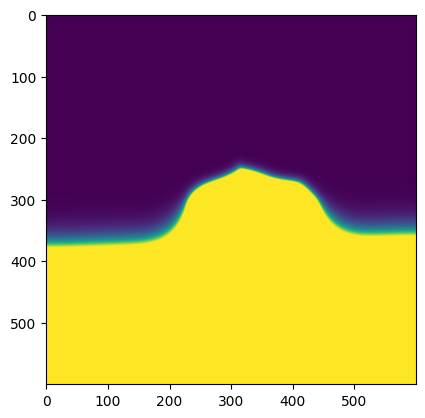

In [62]:
plt.imshow(states[10].v)